## Example: Compute in-scattering

In this example we will compute the in-scattering probability using different techiques, and see the effect it has in the wavelength dependent transmission.

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    from importlib.util import find_spec as _fs
    if not _fs('NCrystal'):
        %pip -q install ncrystal ipympl numpy matplotlib tqdm
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009007, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


### Additional modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

## Example 1
Compute the in-scattering probability for a graphite sample, with a detector that covers 10 degree from the beam axis.

For a first attempt, we can use the function `sampleScatterIsotropic()` with the `repeat` argument, to sample multiple times a scattering event with a fixed incident energy:

In [3]:
thickness = 1.0 # cm
max_theta = 10 # deg

In [4]:
cfg = 'C_sg194_pyrolytic_graphite.ncmat'
mat = NC.load(cfg)

In [5]:
wl1 = np.linspace(1,8,351)
N = 1000000
P_non_absorption = np.exp(-thickness*mat.info.getNumberDensity()*mat.absorption.xsect(wl=wl1))
P_non_scatttering = np.exp(-thickness*mat.info.getNumberDensity()*mat.scatter.xsect(wl=wl1))
P_forward = []
min_mu = np.cos(max_theta*np.pi/180.0)
for wl in tqdm.notebook.tqdm(wl1, total=len(wl1)):
  E_vals, mu_vals = mat.scatter.sampleScatterIsotropic(ekin=NC.wl2ekin(wl), repeat=N)
  forward_count = (mu_vals > min_mu).sum()
  P_forward.append(forward_count/N)

  0%|          | 0/351 [00:00<?, ?it/s]

We compare this with the theoretical transmission computed from the macroscopic total cross section:

In [6]:
wl0 = np.linspace(1,8,1000)
xs = (mat.scatter.xsect(wl=wl0)+mat.absorption.xsect(wl=wl0))
dens = mat.info.getNumberDensity()
transmission0 = np.exp(-dens*xs*thickness)

Text(0, 0.5, 'Transmission')

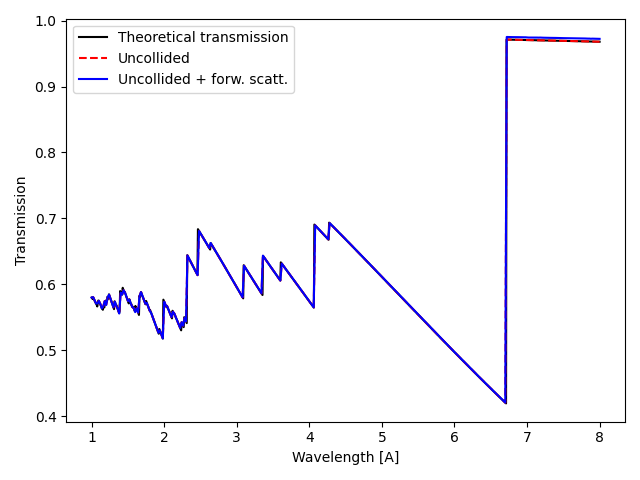

In [7]:
plt.figure()
plt.plot(wl0, transmission0, 'k', label = 'Theoretical transmission')
plt.plot(wl1, P_non_absorption*P_non_scatttering, 'r--', label = 'Uncollided')
plt.plot(wl1, P_non_absorption*P_non_scatttering+P_forward, 'b-', label = 'Uncollided + forw. scatt.')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Transmission')

The effect is actually very small. We can check by computing the probability near the longest Bragg edge:

In [8]:
wl = 6.7 # A
E_vals, mu_vals = mat.scatter.sampleScatterIsotropic(ekin=NC.wl2ekin(wl), repeat=N)
theta_vals = np.arccos(mu_vals)*180.0/np.pi
count = (theta_vals < max_theta).sum()
print(f' The probability of forward scattering below {max_theta:.1f} deg is {count/N:.3e}')

 The probability of forward scattering below 10.0 deg is 1.300e-04


and plot the distribution:

Text(0, 0.5, 'Counts per bin')

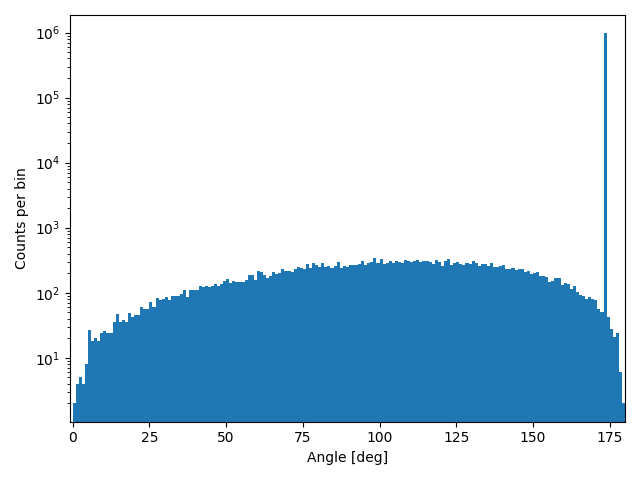

In [9]:
theta_bins = np.linspace(0,180,181)
plt.figure()
a = plt.hist(theta_vals,bins=theta_bins, density=False)
plt.yscale('log')
plt.xlim(-1,180)
plt.xlabel('Angle [deg]')
plt.ylabel('Counts per bin')

We will now repeat the exercise but using the mini Monte Carlo included in NCrystal

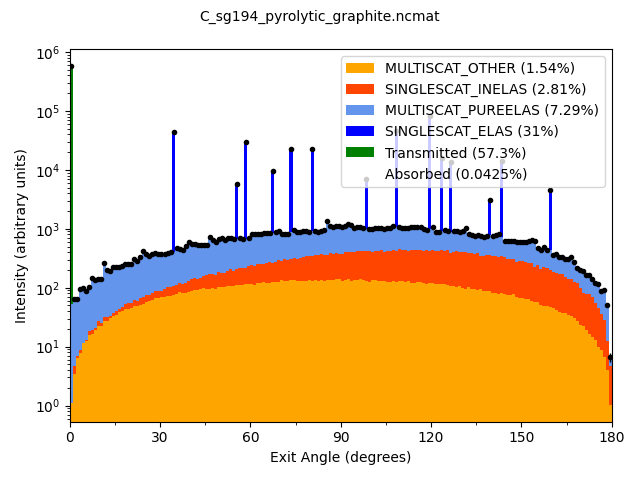

In [10]:
import NCrystal._mmc as ncmmc
result = ncmmc.quick_diffraction_pattern(cfg,
                                           neutron_energy = f'{2} Aa',
                                           material_thickness = f'{thickness}cm')

result.plot_breakdown(rebin_factor=10,logy=True)

The `Results` class includes properties that can be used to access the histograms:

In [11]:
help(result)

Help on Results in module NCrystal._mmc object:

class Results(builtins.object)
 |  Results(main_hist_content, main_hist_errsq, json_details, cfgstr, setup_info)
 |
 |  Methods defined here:
 |
 |  __init__(self, main_hist_content, main_hist_errsq, json_details, cfgstr, setup_info)
 |
 |  histogram_sum(self, *, select=None, exclude=None)
 |
 |  plot(self, *, do_show=True, do_newfig=True, do_grid=False, logy=False, rebin_factor=1, hist=None, title=None, plt=None)
 |
 |  plot_breakdown(self, **kwargs)
 |
 |  plot_main(self, **kwargs)
 |
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |
 |  cfgstr
 |
 |  histogram_breakdown
 |
 |  histogram_main
 |
 |  histograms
 |
 |  setup_info
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __weakref__
 |      list of weak references to the object



In particular, `Results.histogram_main` allows to access the breakdown of the scattering events:

In [12]:
print(result.histogram_breakdown.keys())

dict_keys(['NOSCAT', 'SINGLESCAT_ELAS', 'SINGLESCAT_INELAS', 'MULTISCAT_PUREELAS', 'MULTISCAT_OTHER'])


and `Results.histogram_main` is the histogram for all particles transmitted and scattered:

In [13]:
print(result.histogram_main.title)

MAIN


The `Hist1D` class includes several useful methods. We will use `Hist1D.integrate()` to get the number of counts in a range.

In [14]:
help(result.histogram_main)

Help on Hist1D in module NCrystal._mmc object:

class Hist1D(builtins.object)
 |  Hist1D(data)
 |
 |  Methods defined here:
 |
 |  __init__(self, data)
 |
 |  add_contents(self, other_hist)
 |
 |  bar_args(self, style=True, **kwargs)
 |
 |  clone(self, rebin_factor=1)
 |
 |  errorbar_args(self, style=True, **kwargs)
 |
 |  integrate(self, xlow, xhigh, tolerance=1e-05)
 |      Returns integrated contents of the histogram over the area
 |      [xlow,xhigh] along with the error of that value in a tuple
 |      (content,error).
 |
 |      This is done translating xlow and xhigh to exact bin edges and then
 |      calling integrate_bins. If that is not possible within the
 |      tolerance, an exception is raised.
 |
 |  integrate_bins(self, bin_low=None, bin_up=None)
 |      Returns integrated contents of the bins [bin_low,bin_up[ along with
 |      the error of that value in a tuple (content,error).
 |
 |      If bin_low is None the integration will start at the first bin and
 |      incl

Finaly `Results.setup_info['nstat']` is the number of simulated particles that will be used for normalization:

In [15]:
result.setup_info['nstat']

1000000.0

We can put these things together to compute the in-scattering probability including multiple scattering effects:

In [16]:
wl2 = np.linspace(1,8,700)
transmission2a = []
transmission2b = []

for wl in tqdm.notebook.tqdm(wl2, total=len(wl2)):
  result = ncmmc.quick_diffraction_pattern(cfg,
                                           neutron_energy = f'{wl} Aa',
                                           material_thickness = f'{thickness}cm',
                                           nstat=1e4)
  transmission2b.append(result.histogram_main.integrate(0,max_theta)[0]/result.setup_info['nstat'])
  transmission2a.append(result.histogram_breakdown['NOSCAT'].integrate(0,max_theta)[0]/result.setup_info['nstat'])

  0%|          | 0/700 [00:00<?, ?it/s]

Text(0, 0.5, 'Transmission')

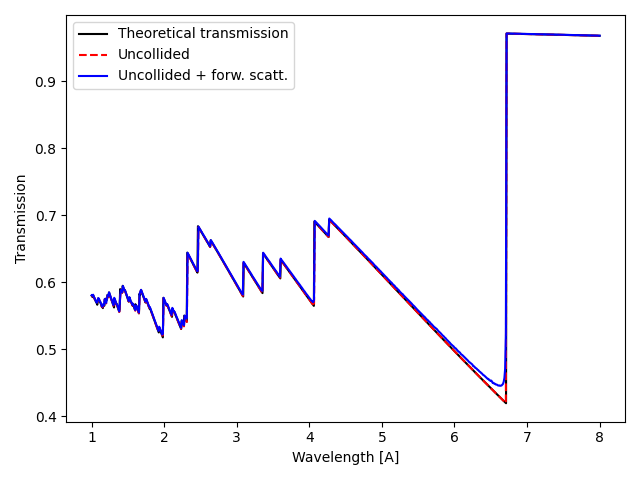

In [17]:
plt.figure()
plt.plot(wl0, transmission0, 'k', label = 'Theoretical transmission')
plt.plot(wl2, transmission2a, 'r--', label = 'Uncollided')
plt.plot(wl2, transmission2b, 'b-', label = 'Uncollided + forw. scatt.')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Transmission')

We can look more in detail why there is a significant in-scattering contribution near the $\lambda = 6.7$ Å Bragg edge:

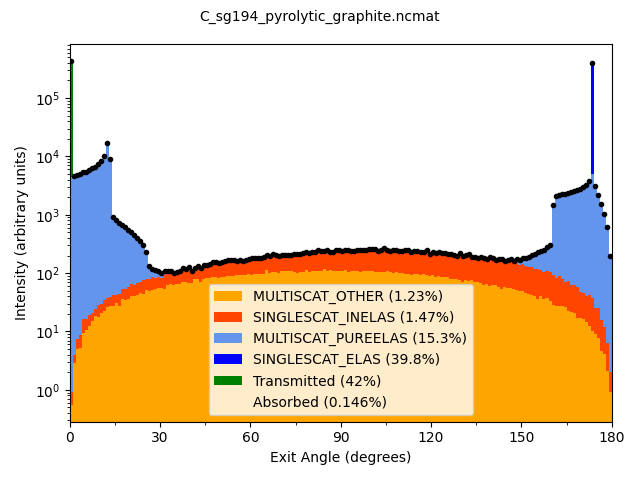

In [18]:
result = ncmmc.quick_diffraction_pattern(cfg,
                                         neutron_energy = f'{6.7} Aa',
                                         material_thickness = f'{thickness}cm')

result.plot_breakdown(rebin_factor=10,logy=True)

compared with the Bragg edge near $\lambda = 4$ Å:

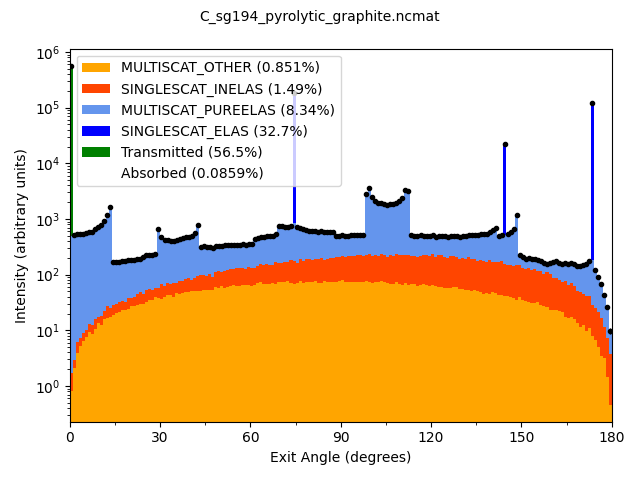

In [19]:
result = ncmmc.quick_diffraction_pattern(cfg,
                                         neutron_energy = f'{4.06} Aa',
                                         material_thickness = f'{thickness}cm')

result.plot_breakdown(rebin_factor=10,logy=True)

As we can see, the isolated Bragg edge at $\lambda = 6.7$ Å has a larger probability of two scattering events near 180 degrees, which send the neutrons back in the forward direction. Whereas in for $\lambda = 4.06$ Å three Bragg edges compete and send neutrons in different directions in multiple scattering events, with a smaller relative contribution in the forward direction.

## Exercise
Repeat the calculation with light water and polyethylene.